# 🐶 End-to-end Multi-class Dog Breed Classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub.

## 1. Problem

Identifying the breed of a dog given an image of a dog.

When i'm sitting at a cafe and I take a photo of a dog, I want to know what breed of dog it is.

## 2. Data

The data we are using is from Kaggle's dog breed identification competition

https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation

The evaluation is a file with prediction probabilities for each dog breed of each text image

Submissions are evaluated on Multi Class Log Loss between the predicted probability and the observed target.

Multi-Class Log Loss, also known as cross-entropy loss or log loss, is a widely used performance metric for evaluating classification models with multiple classes. It measures the dissimilarity between predicted probabilities and actual class labels.

Mathematical Formulation
Log_loss = -(1/N) * sum(y_true * log(y_pred))

The objective is to minimize this loss function, thereby improving the accuracy and reliability of the classification model.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

## 4. Feature

Some information about the data:
* We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10,000+ images in the training set (these images have labels).
* There are around 10,000+ images in the test set (these images have no labels, because we'll want to predict them)

In [47]:
# Unzip the uploaded data into Google Drive
!unzip "drive/MyDrive/Dog Vision/dog-breed-identification.zip" -d "drive/MyDrive/Dog Vision/"    # -d stands for destination

Archive:  drive/MyDrive/Dog Vision/dog-breed-identification.zip
replace drive/MyDrive/Dog Vision/labels.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: drive/MyDrive/Dog Vision/labels.csv  
  inflating: drive/MyDrive/Dog Vision/sample_submission.csv  
  inflating: drive/MyDrive/Dog Vision/test/000621fb3cbb32d8935728e48679680e.jpg  
  inflating: drive/MyDrive/Dog Vision/test/00102ee9d8eb90812350685311fe5890.jpg  
  inflating: drive/MyDrive/Dog Vision/test/0012a730dfa437f5f3613fb75efcd4ce.jpg  
  inflating: drive/MyDrive/Dog Vision/test/001510bc8570bbeee98c8d80c8a95ec1.jpg  
  inflating: drive/MyDrive/Dog Vision/test/001a5f3114548acdefa3d4da05474c2e.jpg  
  inflating: drive/MyDrive/Dog Vision/test/00225dcd3e4d2410dd53239f95c0352f.jpg  
  inflating: drive/MyDrive/Dog Vision/test/002c2a3117c2193b4d26400ce431eebd.jpg  
  inflating: drive/MyDrive/Dog Vision/test/002c58d413a521ae8d1a5daeb35fc803.jpg  
  inflating: drive/MyDrive/Dog Vision/test/002f80396f1e3db687c5932d7978b196.jpg  


### Get our workspace ready

* Import TensorFlow 2.x
* Import TensorFlow Hub
* Make sure we're using a GPU

In [46]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")    # GO FUCK YOURSELF GOOGLE

TF version: 2.17.1
Hub version: 0.16.1
GPU is NOT AVAILABLE


## Getting our data ready (turning our data into Tensors)

With all machine learning models, our data has to be in numerical format. So that's what we'll be doing first. Turning our images into Tensors (numerical representation).

Let's start by accessing our data and checking out the labels.

In [ ]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("drive/MyDrive/Dog Vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


There are 10222 unique ids and there are 120 unique breeds. And that's how the id and breed columns look like, it is showing the first 5 rows.

In [ ]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [ ]:
# How many images are there of each breed?
labels_csv["breed"].value_counts()

breed
scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: count, Length: 120, dtype: int64

<Axes: xlabel='breed'>

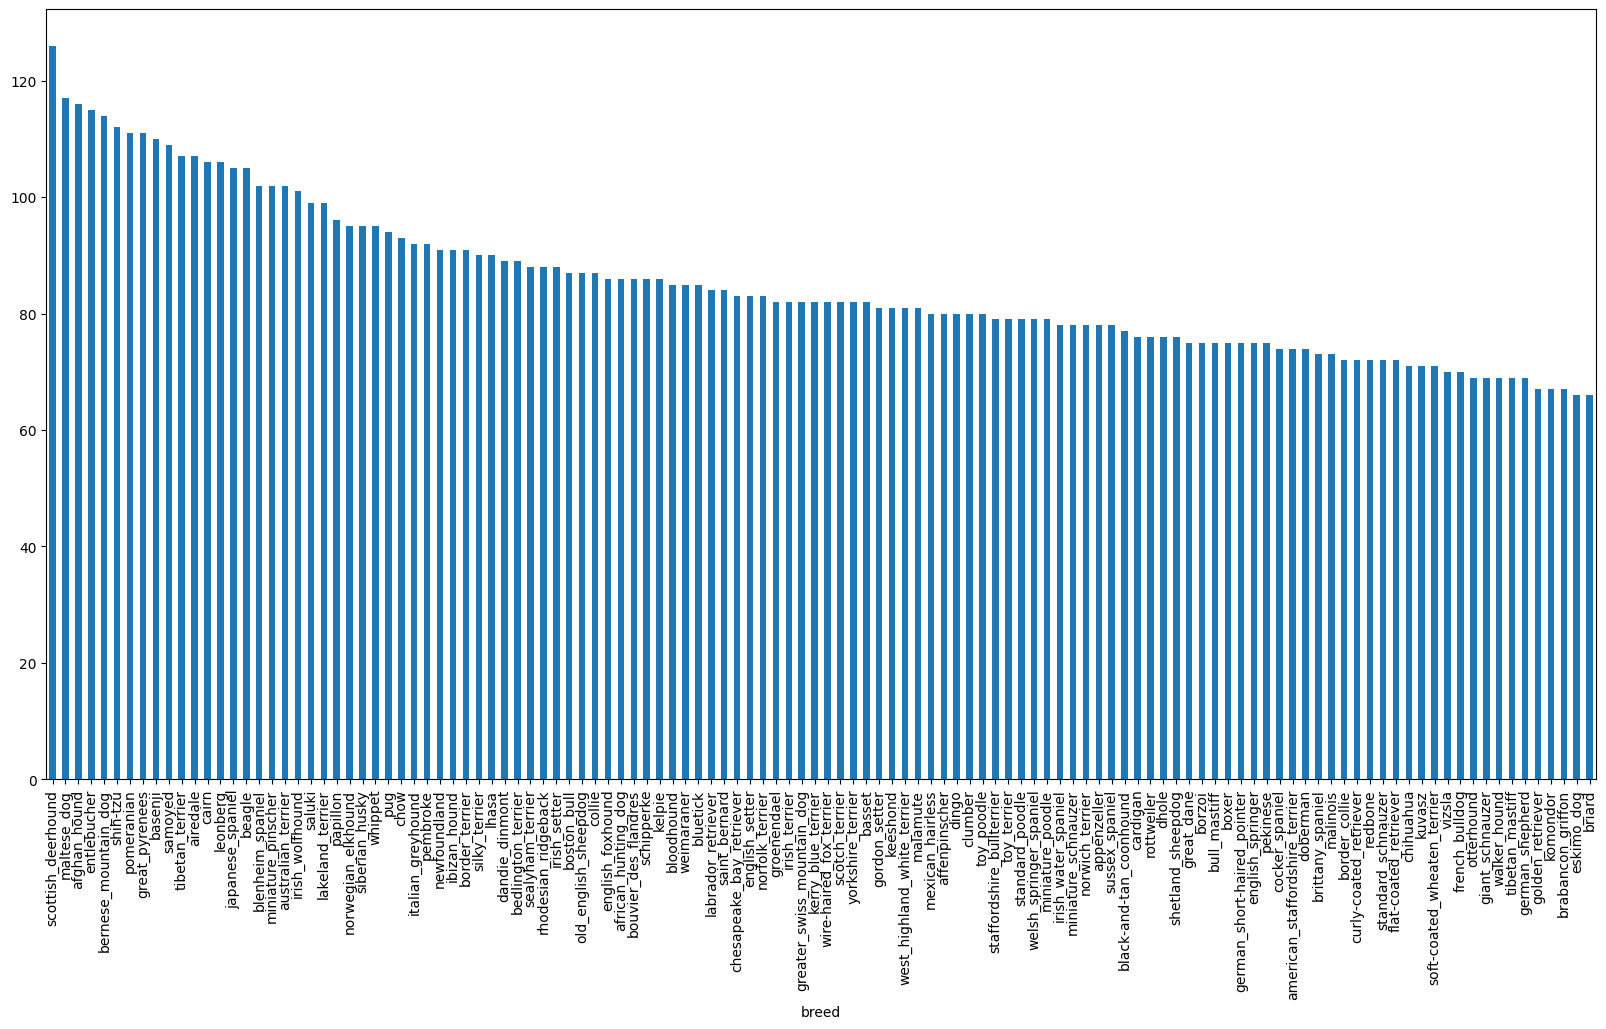

In [ ]:
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10))

The graphics shows the numbers of images each breed has. If we only had only three images of eskimo dog, we could imagine our machine learning model might do very well at figuring out what a scottish_deerhound looks like because it has so many examples, but as for an eskimo dog, if there's only three images, it's probably going to be a bit hard to figure out what it looks like.

In [ ]:
labels_csv["breed"].value_counts().median()

82.0

Google says that for each label you must have at least 10 images, each with at least one annotation (bounding box and the label)

However, for model training purposes, Google says it's recommended you use about 100 annotations per label.

In our data set there are about 75 to 85 images per class, it is pretty well spread out.

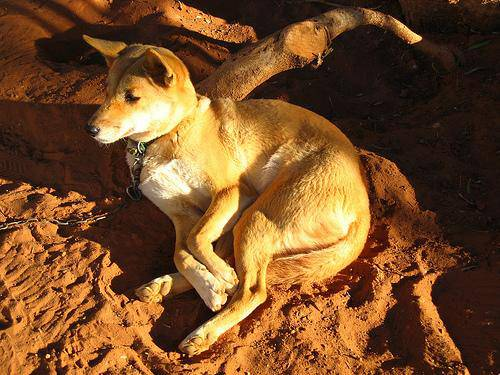

In [ ]:
# Let's view an image
from IPython.display import Image
Image("drive/MyDrive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

### Getting images and their labels

Let's get a list of all of our image file pathnames.

In [ ]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [ ]:
# Create pathnames from image ID's
filenames = ["drive/MyDrive/Dog Vision/train/" + fname + ".jpg" for fname in labels_csv["id"]]

# Check the first 10
filenames[:10]

['drive/MyDrive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [ ]:
# Check whether number of filenames matches number of actual image files
import os
if len(os.listdir("drive/MyDrive/Dog Vision/train/")) == len(filenames):
  print("Filenames match actual amount of files!!! Proceed.")
else:
  print("Filenames do not match actual amount of files, check the target directory.")

Filenames match actual amount of files!!! Proceed.


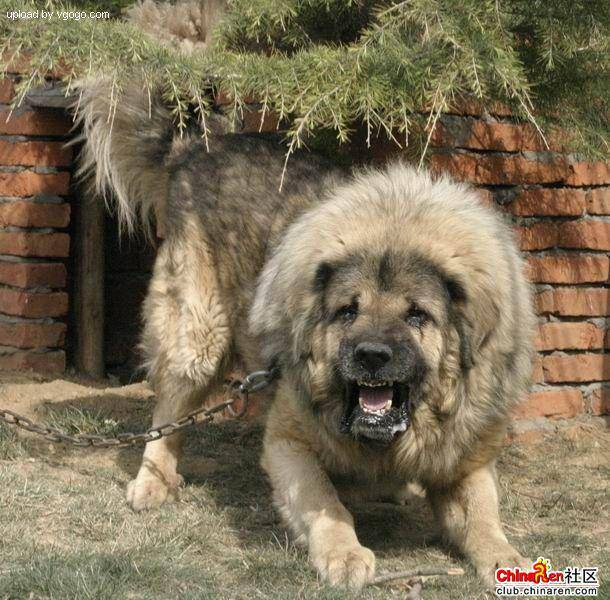

In [ ]:
# One more check
Image(filenames[9000])

In [ ]:
labels_csv["breed"][9000]

'tibetan_mastiff'

Since we've now got our training image filepaths in a list, let's prepare our labels.

In [ ]:
import numpy as np
labels = labels_csv["breed"]
labels

0                     boston_bull
1                           dingo
2                        pekinese
3                        bluetick
4                golden_retriever
                   ...           
10217                      borzoi
10218              dandie_dinmont
10219                    airedale
10220          miniature_pinscher
10221    chesapeake_bay_retriever
Name: breed, Length: 10222, dtype: object

In [ ]:
labels = labels_csv["breed"].to_numpy()
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [ ]:
labels = np.array(labels)    # it does the same thing as above
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [ ]:
len(labels)

10222

In [ ]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames!")
else:
  print("Number of labels does not matches number of filenames!")

Number of labels matches number of filenames!


In [ ]:
# Find the unique label values
unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [ ]:
len(unique_breeds)

120

In [ ]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [ ]:
# Retorna un vector que contiene todos valores False excepto en las posiciones donde aparece
# boston_bull, en donde aparecerán los valores True.

In [ ]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [ ]:
len(boolean_labels)

10222

In [ ]:
# Example: Turning boolean array into integers
print(labels[0])
print(np.where(unique_breeds == labels[0]))    # index where label occurs
print(boolean_labels[0].argmax())    # index where label occurs in boolean array
print(boolean_labels[0].astype(int))    # there will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [ ]:
print(labels[2])
print(boolean_labels[2].astype(int))

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [ ]:
filenames[:10]

['drive/MyDrive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

### Creating our own validation set

Since the dataset from Kaggle doesn't come with a validation set, we're going to create our own.

In [ ]:
# Setup X & y variables
X = filenames
y = boolean_labels

In [ ]:
len(filenames)

10222

It's a good a idea to start working with a portion of the filenames first to make sure things are working before we go and train a machine learning model on all of them.


We're going to start off experimenting with ~1000 images and increase as needed.

In [ ]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [ ]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)
len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [ ]:
# Let's have a geez at the training data
X_train[:2], y_train[:2]

(['drive/MyDrive/Dog Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/MyDrive/Dog Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, Fal

In [ ]:
# X values are the file paths to our images and Y values,
# the labels, are boolean numpy representations of the labels

## Preprocessing Images (turning images into Tensors)

To preprocess our images into Tensors we're going to write a function which does a few things:
1. Take an image filepath as input.
2. Use Tensorflow to read the file and save it to a variable,  `image`.
3. Turn our `image` (a jpg) into Tensors.
4. Resize the `image`to be a shape of (224, 224).
5. Return the modified `image`.

Before we do, let's see what importing an image looks like.


In [ ]:
# Convert an image to a NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape
# Tensors are very similar to multi dimensional numpy array or matrices

(257, 350, 3)

In [ ]:
# height, width, color channel (RGB)
# each pixel in an image is some combination of red, green and blue, and they range from 0 to 255

array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]],

       [[ 56, 104,  66],
        [ 58, 106,  68],
        [ 64, 112,  74],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 74, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  11],
        [  8,  14,  14],
        ...,
        [120, 113,  67],
        [126, 118,  71],
        [122, 114,  67]],

       [[  0,   3,   7],
        [  2,   7,  10],
        [  3,   9,   7],
        ...,
        [105,  98,  54],
        [112, 104,  58],
        [111, 103,  57]],

       [[ 16,  18,  30],
        [ 16,  19,  24],
        [ 15,  20,  14],
        ...,
        [101,  92,  51],
        [ 97,  88,  47],
        [120, 111,  70]]], dtype=uint8)
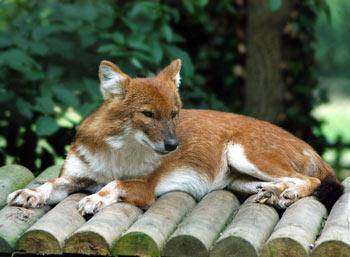

In [ ]:
image

In [ ]:
image.min(), image.max()

(0, 255)

In [ ]:
image[:2]    # This is a numpy ndarray

array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)

In [ ]:
# Turn image into a tensor
tf.constant(image)
# Creates a constant tensor from a tensor-like object.


<tf.Tensor: shape=(257, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]],

       [[ 56, 104,  66],
        [ 58, 106,  68],
        [ 64, 112,  74],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 74, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  11],
        [  8,  14,  14],
        ...,
        [120, 113,  67],
        [126, 118,  71],
        [122, 114,  67]],

       [[  0,   3,   7],
        [  2,   7,  10],
        [  3,   9,   7],
        ...,
        [105,  98,  54],
        [112, 104,  58],
        [111, 103,  57]],

       [[ 16,  18,  30],
        [ 16,  19,  24],
        [ 15,  20,  14],
        ...,
        [101,  92,  5

In [ ]:
# This is a tensor, and now is able to run on a GPU, so a lot faster than a CPU (we've seen an example that GPU runs 30X faster than CPU)

array([[[178, 165, 131],
        [179, 166, 132],
        [182, 167, 134],
        ...,
        [ 59,  45,  36],
        [ 52,  39,  30],
        [ 39,  29,  19]],

       [[176, 163, 129],
        [178, 165, 131],
        [180, 165, 132],
        ...,
        [ 61,  47,  38],
        [ 54,  41,  32],
        [ 41,  31,  21]],

       [[175, 162, 130],
        [176, 163, 131],
        [179, 164, 131],
        ...,
        [ 63,  49,  40],
        [ 55,  42,  33],
        [ 44,  34,  24]],

       ...,

       [[117, 112,  93],
        [124, 119, 100],
        [136, 129, 111],
        ...,
        [128, 100,  78],
        [146, 119,  98],
        [165, 139, 126]],

       [[125, 120, 101],
        [128, 123, 104],
        [136, 129, 111],
        ...,
        [142, 114,  92],
        [157, 130, 109],
        [170, 144, 131]],

       [[134, 129, 110],
        [135, 130, 111],
        [139, 132, 114],
        ...,
        [149, 121,  99],
        [161, 134, 113],
        [165, 139, 126]]], dtype=uint8)
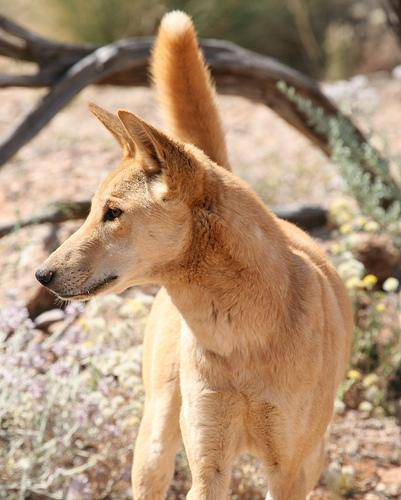

In [ ]:
image2 = imread(filenames[43])
image2

In [ ]:
image2[:3]    # this is an array

array([[[178, 165, 131],
        [179, 166, 132],
        [182, 167, 134],
        ...,
        [ 59,  45,  36],
        [ 52,  39,  30],
        [ 39,  29,  19]],

       [[176, 163, 129],
        [178, 165, 131],
        [180, 165, 132],
        ...,
        [ 61,  47,  38],
        [ 54,  41,  32],
        [ 41,  31,  21]],

       [[175, 162, 130],
        [176, 163, 131],
        [179, 164, 131],
        ...,
        [ 63,  49,  40],
        [ 55,  42,  33],
        [ 44,  34,  24]]], dtype=uint8)

In [ ]:
# Turn image2 into a tensor
tf.constant(image)

<tf.Tensor: shape=(257, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]],

       [[ 56, 104,  66],
        [ 58, 106,  68],
        [ 64, 112,  74],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 74, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  11],
        [  8,  14,  14],
        ...,
        [120, 113,  67],
        [126, 118,  71],
        [122, 114,  67]],

       [[  0,   3,   7],
        [  2,   7,  10],
        [  3,   9,   7],
        ...,
        [105,  98,  54],
        [112, 104,  58],
        [111, 103,  57]],

       [[ 16,  18,  30],
        [ 16,  19,  24],
        [ 15,  20,  14],
        ...,
        [101,  92,  5

Now we've seen what an image looks like as a Tensor, let's make a function to preprocess them.

1. Take an image filepath as input.
2. Use Tensorflow to read the file and save it to a variable,  `image`.
3. Turn our `image` (a jpg) into Tensors.
4. Resize the `image`to be a shape of (224, 224).
5. Return the modified `image`.

In [ ]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes an image filepath and turns the image into a Tensor
  """
  # Read in an image file
  image = tf.io.read_file(image_path) # Reads the contents of file. This operation returns a tensor with the entire contents of the input filename.
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values to from 0 to 255 to 0-1 values (Normalization)
  image = tf.image.convert_image_dtype(image, tf.float32)   # convert image to dtype, scaling its values if needed
  # Resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

TensorFlow likes to see things in the form of a data batch, that is to say, a tensor containing an image example or a piece of data example. So it likes it in the form of give me a piece of data and its label as a combined tensor so I can process it really fast.

A batch, is also called a mini batch, that is to say, is a small portion of your data. The default batch size is generally 32 with most deep learning models. It is demonstrated that the rate of learning of the deep neural network reaches its best performance if the number of samples per batch is m=32: https://arxiv.org/abs/1804.07612

## Turning our data into batches

We're just taking a small portion, 32 images and calculating on those 32 images at on time. And then, the next loop, the next training session, we calculate on the next 32. Because if we try to calculate patterns in all 10,000 images, Let's say you're trying to process 10,000+ images in one go... they all might not fit into memory. A GPU, although it's really fast to computing, it still has a limited amount of memory.

So that's wht we do about 32 images (this is the batch size) at a time (you can manually adjust the batch size if need be).

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this:
`(image, label)` <- we pass 32 at a time to our machine learning model, img is in tensor format, and it's going to fing the pattern in this image that relate to this label, and then it will end up doing that in a sort of loop fashion until it gets through all 10,000+ images



In [ ]:
# Create a simple function to return a tuple of tensors of the form (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the assosciated label,
  processes the image and returns a tuple of (image, label).
  """
  image = process_image(image_path)
  return image, label

In [ ]:
# Demonstration of the above
(process_image(X[42], tf.constant(y[42])))    # (data in the form of tensor, label in the form of tensor)

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.3264178 , 0.5222886 , 0.3232816 ],
        [0.2537167 , 0.44366494, 0.24117759],
        [0.25699762, 0.4467087 , 0.23893751],
        ...,
        [0.29325107, 0.5189916 , 0.3215547 ],
        [0.29721776, 0.52466875, 0.33030328],
        [0.2948505 , 0.5223015 , 0.33406618]],

       [[0.25903144, 0.4537807 , 0.27294815],
        [0.24375686, 0.4407019 , 0.2554778 ],
        [0.2838985 , 0.47213382, 0.28298813],
        ...,
        [0.2785345 , 0.5027992 , 0.31004712],
        [0.28428748, 0.5108719 , 0.32523635],
        [0.28821915, 0.5148036 , 0.32916805]],

       [[0.20941195, 0.40692952, 0.25792548],
        [0.24045378, 0.43900946, 0.2868911 ],
        [0.29001117, 0.47937486, 0.32247734],
        ...,
        [0.26074055, 0.48414773, 0.30125174],
        [0.27101526, 0.49454468, 0.32096273],
        [0.27939945, 0.5029289 , 0.32934693]],

       ...,

       [[0.00634795, 0.03442048, 0.0258106 ],
        [0.01

In [ ]:
# So now we've got a tuple of an image and a label pair, in the form of tensors. a tuple of tensors.

Now we've got a way to turn our data into tuples of Tensors in the form: `(image, label)`, let's make a function to turn all of our data (`X` & `y`) into batches ! # READ THROUGH THE DOCUMENTATION

In [ ]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't suffle if it's validation data.
  Also accepts test data as input (no labels)
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))   # only pathfiles (no labels)
    # we're making a batch dataset. Creates a Dataset whose elements are slices of the given tensors.
    # you can read my comments but you don't let me use the GPU. THANK YOU FOR LETTING ME FINISH MY COURSE, GOOGLE
    # I'm going to create a tensorflow (tf) dataset, from the tensor slices, X, and because we're passing X to tf.constant
    # it turns X into a tensor.
    data_batch = data.map(process_image).batch(BATCH_SIZE)    # Take the tf dataset made of X (which is filenames in the form of tensors) and then map our process image f(x)
    return data_batch                                         # it executes all the instructions of f(X), and then turn it into a batch of BATCH_SIZE

  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),  # filepaths     # it says "pass me some tensors and i'll create some Dataset out of that"
                                               tf.constant(y))) # labels    # because we are passing to tf.constat() it turns X into a tensor
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),     # image filepaths
                                               tf.constant(y)))    # labels # we pass it a tuple of (X, y) in the form of tensor both
    # Shuffling pathnames and labels befor mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))    # It shuffles the 10222 images..
                                               # buffer_size it stans for how many variables we want to shuffle, we want to shuffle it up all the variables
    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
    return data_batch

# process_image let us process the img if we have no labels
# if we have labels we can use the function get_image_label

In [ ]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [ ]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),\
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)) This is our training data\

  (None, 224, 224, 3) this is our image, None is for batchsize (32 by default) and it has a shape of img_height=224, img_width=224, and number_channels=3 (r,g,b)

TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)) These are image label pairs in the form of tensors, and our labels also have a batch shape of None, and they have a dimension of 120, because there's a 120 dog breeds.


In [ ]:
y[0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

break down the function and check what it does line by line to understand its behavior.

### Visualizing Data Batches

Our data is now in batches, however, these can be a little hard to understand/comprehend, let's visualize them!

In [ ]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch
  """
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (num_rows=5, num_columns=5, index=i+1)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])    # we want to show the ith image
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    plt.tight_layout()
    # Turn the grid lines off
    plt.axis("off")


In [ ]:
train_data  # because train_data is in the form of a batch we need to turn it into an iterator, so we can de-batch the training data and work with just one bat paso
            # and we can do that by calling the function as_numpy_iterator(), this is going to take our batch dataset and it's going to unwind it from a batch and
            # turn it into a numpy iterator (de modo que podamos recorrer iterador paso a paso a fin de obtener lotes de datos.. doy un paso y obtengo un lote de 32
            # imagenes, doy otro paso y obtengo otro lote de 32 imagenes y asi sucesivamente.)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [ ]:
train_images, train_labels = next(train_data.as_numpy_iterator()) # Returns an iterator which converts all elements of the dataset to numpy, into an array (iterable)
train_images, train_labels    # next: takes the batch from the top, it returns the next item of an iterators
                              # and then thanks to next, it's going to grab the first batch of the top of this out iterator.
                              #and the because it splits it (train_images, train_labels)
                              # is going to assign TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None) to train_images and
                              # is going to assign TensorSpec(shape=(None, 120), dtype=tf.bool, name=None) to train_labels

(array([[[[3.88235331e-01, 1.80392161e-01, 1.17647067e-01],
          [3.93767536e-01, 1.85924381e-01, 1.23179279e-01],
          [3.98074269e-01, 1.90231115e-01, 1.27486005e-01],
          ...,
          [3.37325037e-01, 2.00210407e-01, 1.27626315e-01],
          [3.34488750e-01, 1.89390734e-01, 1.18802488e-01],
          [3.37254912e-01, 1.92156881e-01, 1.21568635e-01]],
 
         [[3.88235331e-01, 1.80392161e-01, 1.17647067e-01],
          [3.91075522e-01, 1.83232352e-01, 1.20487258e-01],
          [3.94257754e-01, 1.86414570e-01, 1.23669475e-01],
          ...,
          [3.41209799e-01, 2.00210407e-01, 1.27626315e-01],
          [3.34488750e-01, 1.89390734e-01, 1.18802488e-01],
          [3.37254912e-01, 1.92156881e-01, 1.21568635e-01]],
 
         [[3.91981840e-01, 1.84138656e-01, 1.21393561e-01],
          [3.97390544e-01, 1.89547390e-01, 1.26802281e-01],
          [3.99738997e-01, 1.91895843e-01, 1.29150733e-01],
          ...,
          [3.39410007e-01, 1.98303655e-01, 1.2571

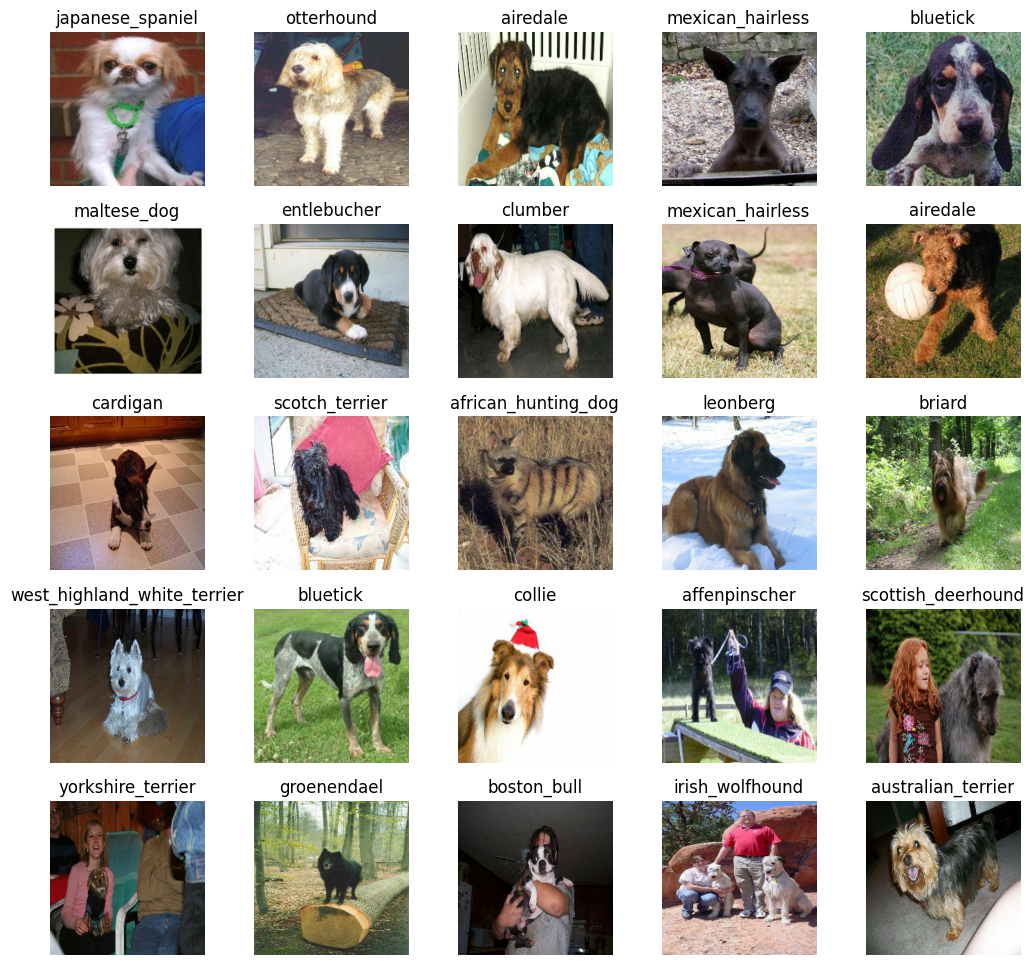

In [ ]:
# Now let's visualize the data in a training batch
show_25_images(train_images, train_labels)

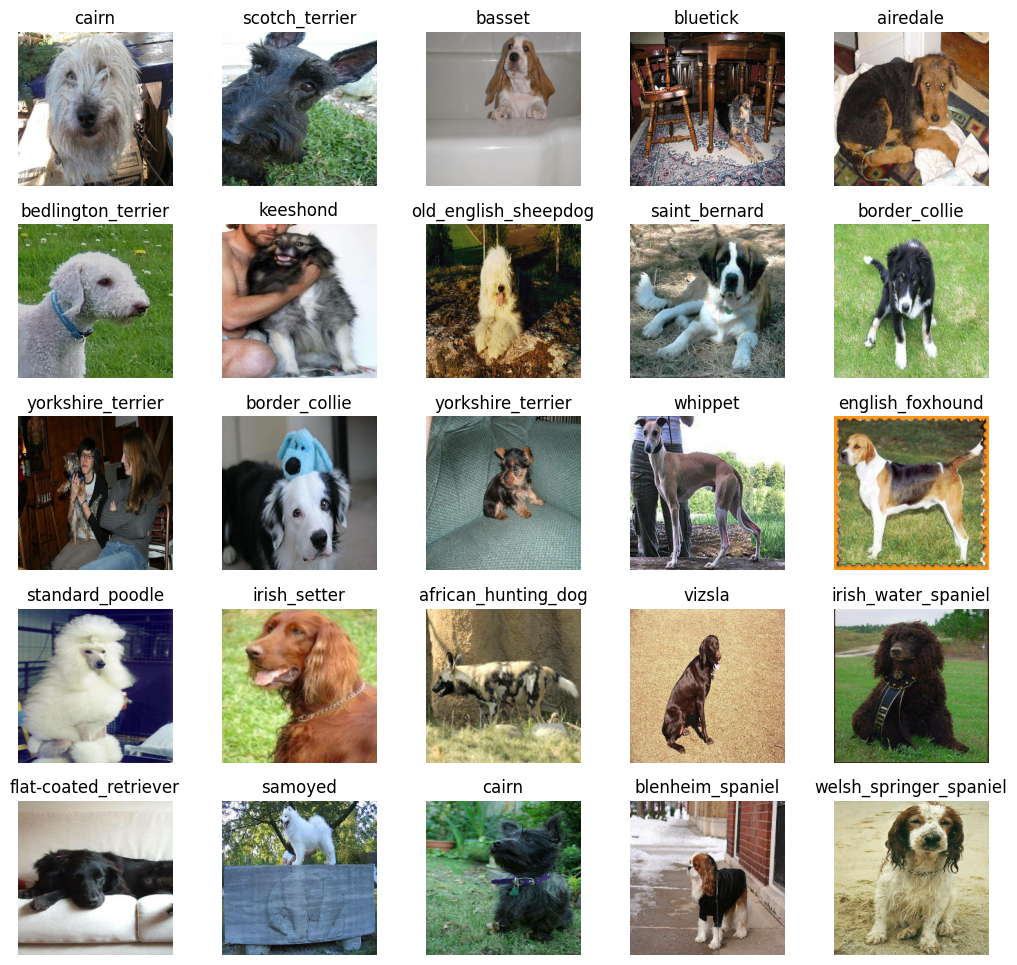

In [ ]:
# Now let's visualize our validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building a model

Before we build a model, there are a few things we need to define:
* The input shape (our images shape, in the form of tensors) to our model.
* The output shape (images labels, in the form of tensors) of our model.
* The URL of the model we want to use

We're going to take what a machine learning model has learned and apply it to our problem, saves us on energy, cost and time.

In [ ]:
# Setup input shape to the model (in the form of tensors of our model)
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3]    # batch, img_height, img_width, colour_channels

# Setup the output shape of our model (in the form of tensors of our model)
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow Hub
MODEL_URL =     # of the model we want to use, to start experimenting as quick as possible
